In [97]:
import hiive.mdptoolbox as mdptoolbox
import hiive.mdptoolbox.example
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import clear_output, display

In [98]:
def get_score(env, policy, printInfo=False, episodes=1000):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps+=1
            if done and reward == 1:
                # print('You have got the Frisbee after {} steps'.format(steps))
                steps_list.append(steps)
                break
            elif done and reward == 0:
                # print("You fell in a hole!")
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100
    
    if (printInfo):
        print('----------------------------------------------')
        print('You took an average of {:.0f} steps to get the frisbee'.format(ave_steps))
        print('And you fell in the hole {:.2f} % of the times'.format(pct_fail))
        print('----------------------------------------------')
  
    return ave_steps, std_steps, pct_fail

In [99]:
colors = {
    0: 'g',
    1: 'k'
}

labels = {
    0: 'W',
    1: 'C',
}

def plot_forest(policy, title='Forest Management'):
    rows = 25
    cols = 25
    
    # reshape policy array to be 2-D - assumes 500 states...
    policy = np.array(list(policy)).reshape(rows,cols)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, xlim=(-.01, cols+0.01), ylim = (-.01, rows+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    
    for i in range(25):
        for j in range(25):
            y = 25 - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[policy[i,j]])
            ax.add_patch(p)
            
            text = ax.text(x+0.5, y+0.5, labels[policy[i, j]],
                           horizontalalignment='center', size=10, verticalalignment='center', color='w')
    
    plt.axis('off')
    plt.show()
    
    
# plot_forest(bestPolicy)

In [100]:
T,R = hiive.mdptoolbox.example.forest(S=625)

In [101]:
def valueIteration(t, r, gammas, epsilons, showResults=False, max_iterations=100000):
    t0 = time.time()
    
    # Create data structure to save results
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(columns=columns)
    
    print('Gamma,\tEps,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for e in epsilons:
            test = ValueIteration(t, r, gamma=g, epsilon=e, max_iter=max_iterations)
            
            runs  = test.run()
            Time  = runs[-1]['Time']
            iters = runs[-1]['Iteration']
            maxR  = runs[-1]['Max V']
            
            max_rewards, mean_rewards, errors = [], [], []
            for run in runs:
                max_rewards.append(run['Max V'])
                mean_rewards.append(run['Mean V'])
                errors.append(run['Error'])
            
            policy = np.array(test.policy)
            
            # Append results to data frame
            data.loc[testNum] = [g, e, Time, iters, maxR, np.mean(mean_rewards), np.std(mean_rewards), np.sum(np.array(mean_rewards) > 0) / len(mean_rewards), test.policy, mean_rewards, max_rewards, errors]
            
            print('%.2f,\t%.0E,\t%.2f,\t%d,\t%f' % (g, e, Time, iters, maxR))
            
            testNum += 1
        
    endTime = time.time() - t0
    print('Time taken: %.2f' % endTime)
    
    # See differences in policy
    policies = data['policy']
    
    return data


In [102]:
gammas   = [0.1, 0.3, 0.6, 0.9, 0.9999999]
epsilons = [1e-2, 1e-3, 1e-8, 1e-12]
vi_data  = valueIteration(T, R, gammas, epsilons, showResults=False)

Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.10,	1E-02,	0.01,	2,	4.360000
0.10,	1E-03,	0.01,	3,	4.393300
0.10,	1E-08,	0.01,	8,	4.396613
0.10,	1E-12,	0.00,	12,	4.396613
0.30,	1E-02,	0.00,	4,	5.460862
0.30,	1E-03,	0.00,	6,	5.489575
0.30,	1E-08,	0.01,	15,	5.491933
0.30,	1E-12,	0.00,	22,	5.491933
0.60,	1E-02,	0.02,	11,	8.797055
0.60,	1E-03,	0.01,	15,	8.808703
0.60,	1E-08,	0.02,	33,	8.809994
0.60,	1E-12,	0.02,	48,	8.809994
0.90,	1E-02,	0.02,	39,	23.089675
0.90,	1E-03,	0.02,	50,	23.147532
0.90,	1E-08,	0.04,	105,	23.172360
0.90,	1E-12,	0.05,	149,	23.172433
1.00,	1E-02,	0.08,	210,	134.486464
1.00,	1E-03,	0.08,	232,	144.907286
1.00,	1E-08,	0.11,	341,	196.537389
1.00,	1E-12,	0.15,	429,	238.219997
Time taken: 0.76


In [103]:
policies = vi_data['policy']

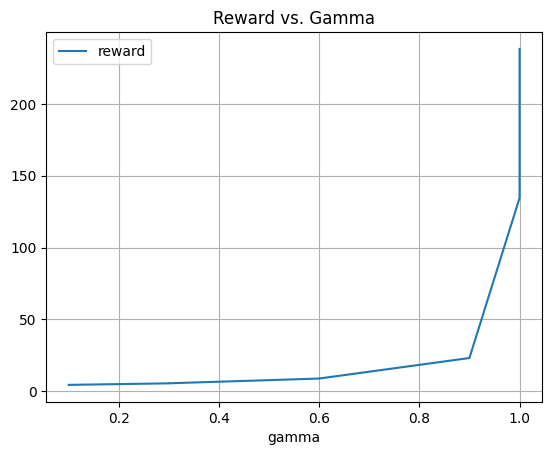

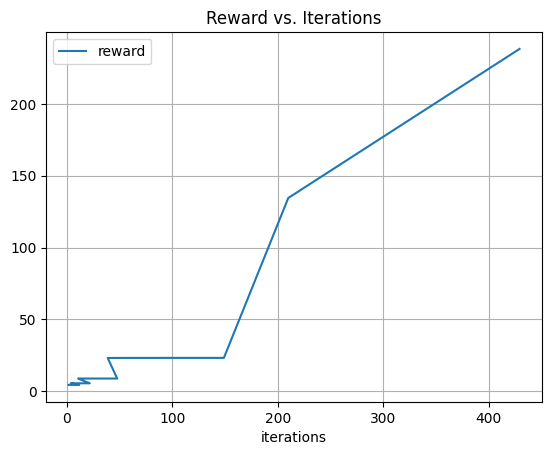

In [104]:
vi_data.plot(x='gamma', y='reward', title="Reward vs. Gamma")
plt.grid()

vi_data.plot(x='iterations', y='reward', title="Reward vs. Iterations")
plt.grid(True)

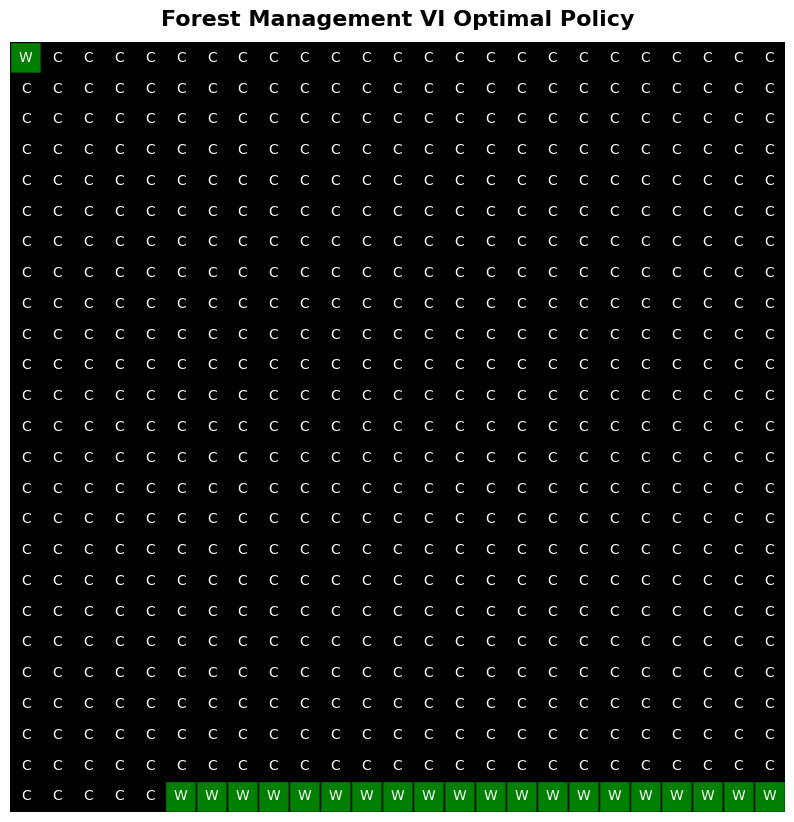

Best Result:
	Reward = 238.22
	Gamma = 0.9999999
	Epsilon= 1E-12


In [105]:
bestRun = vi_data['reward'].argmax()
bestPolicy = vi_data['policy'][bestRun]

title='Forest Management VI Optimal Policy'
plot_forest(bestPolicy, title)

print('Best Result:\n\tReward = %.2f\n\tGamma = %.7f\n\tEpsilon= %.E' % (vi_data['reward'].max(), vi_data['gamma'][bestRun], vi_data['epsilon'][bestRun]))

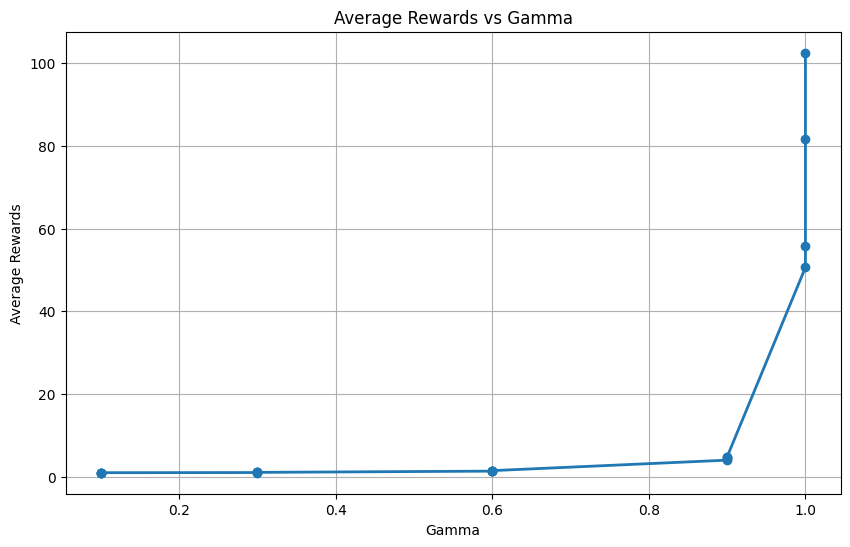

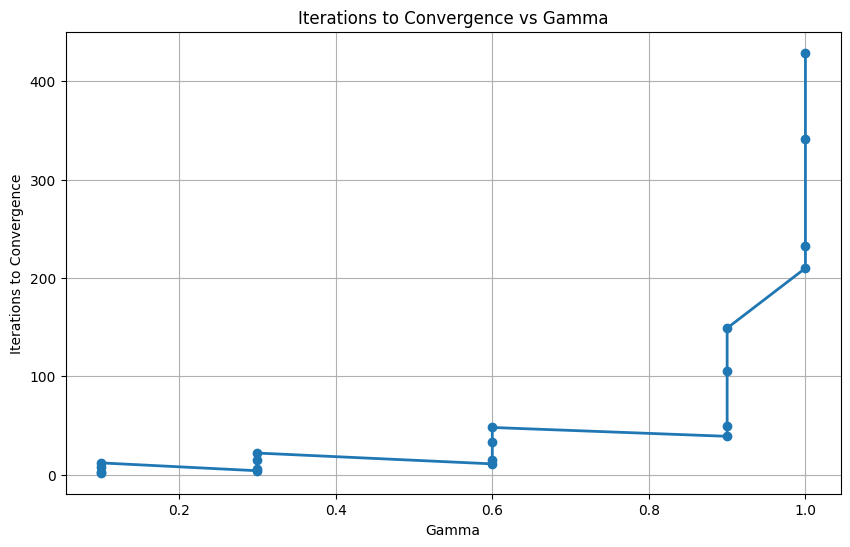

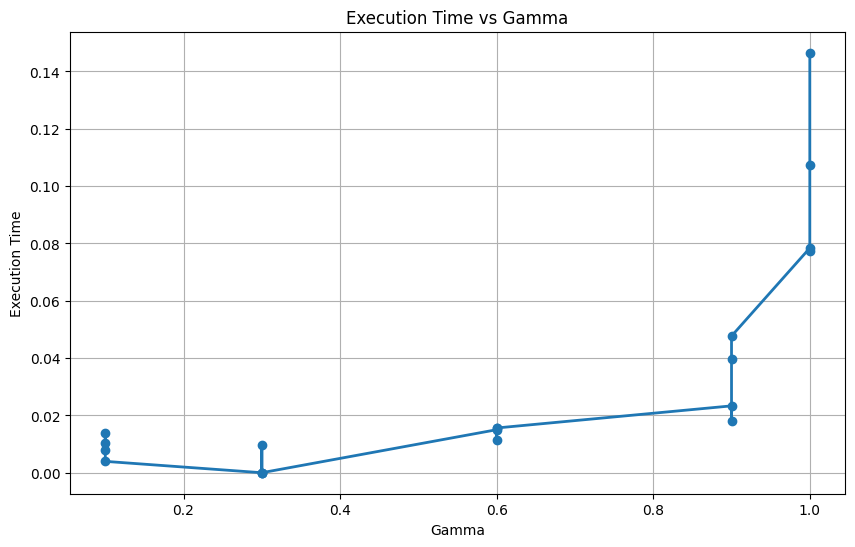

In [106]:
def plot_results(data):
    # Plot Average rewards vs gamma
    plt.figure(figsize=(10, 6))
    plt.plot(data['gamma'], data['average_steps'], marker='o', linestyle='-', linewidth=2)
    plt.xlabel('Gamma')
    plt.ylabel('Average Rewards')
    plt.title('Average Rewards vs Gamma')
    plt.grid(True)
    plt.show()

    # Plot Iteration to convergence vs gamma
    plt.figure(figsize=(10, 6))
    plt.plot(data['gamma'], data['iterations'], marker='o', linestyle='-', linewidth=2)
    plt.xlabel('Gamma')
    plt.ylabel('Iterations to Convergence')
    plt.title('Iterations to Convergence vs Gamma')
    plt.grid(True)
    plt.show()

    # Plot Execution time vs gamma
    plt.figure(figsize=(10, 6))
    plt.plot(data['gamma'], data['time'], marker='o', linestyle='-', linewidth=2)
    plt.xlabel('Gamma')
    plt.ylabel('Execution Time')
    plt.title('Execution Time vs Gamma')
    plt.grid(True)
    plt.show()
plot_results(vi_data)

In [128]:
def policyIteration(t, r, gammas, showResults=False, max_iterations=100000):
    t0 = time.time()
    
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)), columns=columns)
    
    print('gamma,\ttime,\titer,\treward')
    print(80*'_')
    
    testnum = 0
    for g in gammas:
        test = PolicyIteration(t, r, gamma=g, max_iter=max_iterations, eval_type="matrix") # eval_type="iterative"
        
        runs  = test.run()
        Time  = test.time
        iters = test.iter
        maxr  = runs[-1]['Max V']
                
        max_rewards, mean_rewards, errors = [], [], []
        for run in runs:
            max_rewards.append(run['Max V'])
            mean_rewards.append(run['Mean V'])
            errors.append(run['Error'])
        
        data['gamma'][testnum]        = g
        data['time'][testnum]         = Time
        data['iterations'][testnum]   = iters
        data['reward'][testnum]       = maxr
        data['mean_rewards'][testnum] = {tuple(mean_rewards)}
        data['max_rewards'][testnum]  = {tuple(max_rewards)}
        data['error'][testnum]        = {tuple(errors)}
        data['policy'][testnum]       = {test.policy}
        
        print('%.2f,\t%.2f,\t%d,\t%f' % (g, Time, iters, maxr))
        
        testnum = testnum + 1
        
    endTime = time.time() - t0
    print('Time taken: %.2f' % endTime)
    
    # see differences in policy
    policies = data['policy']
        
    # replace all nan's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

In [ ]:
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999]
pi_data  = policyIteration(T, R, gammas, showResults=False)

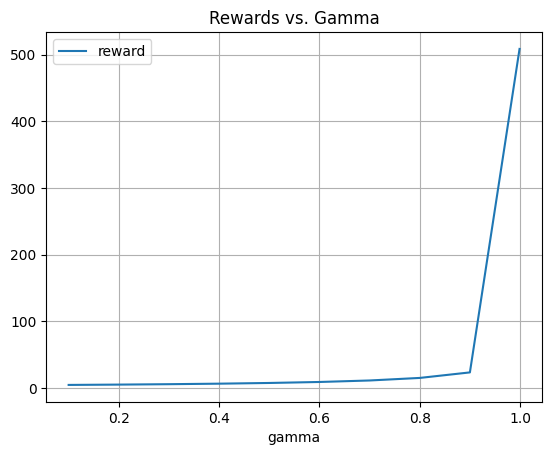

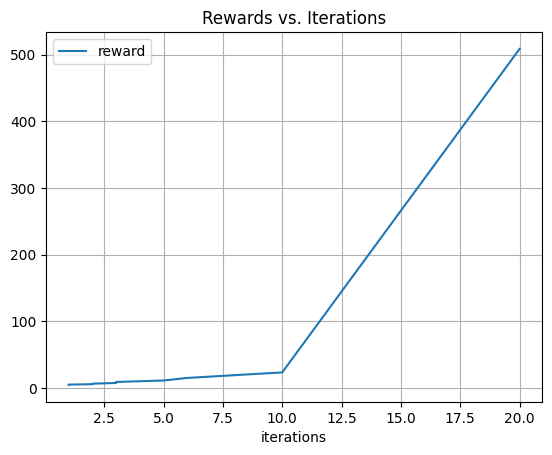

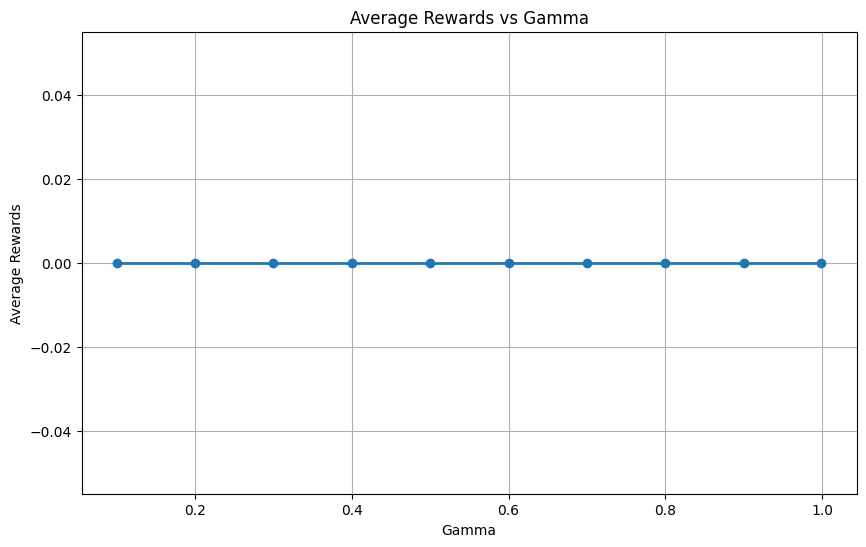

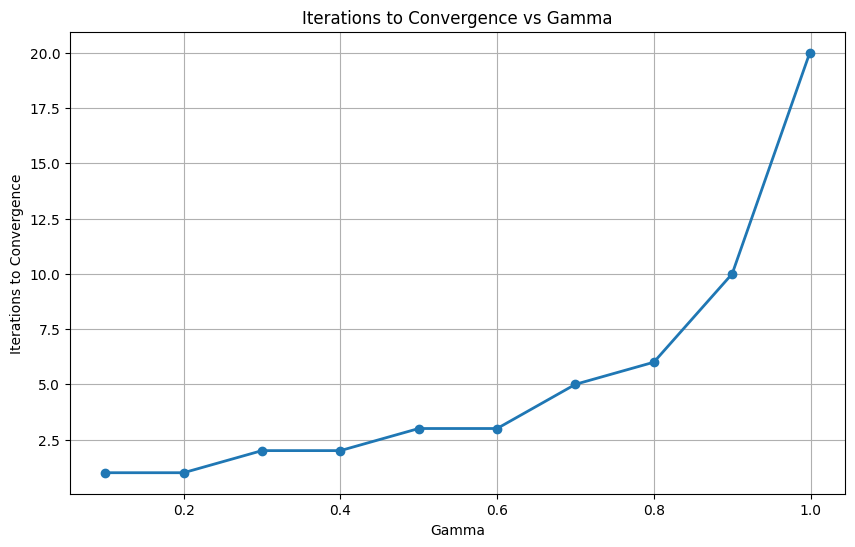

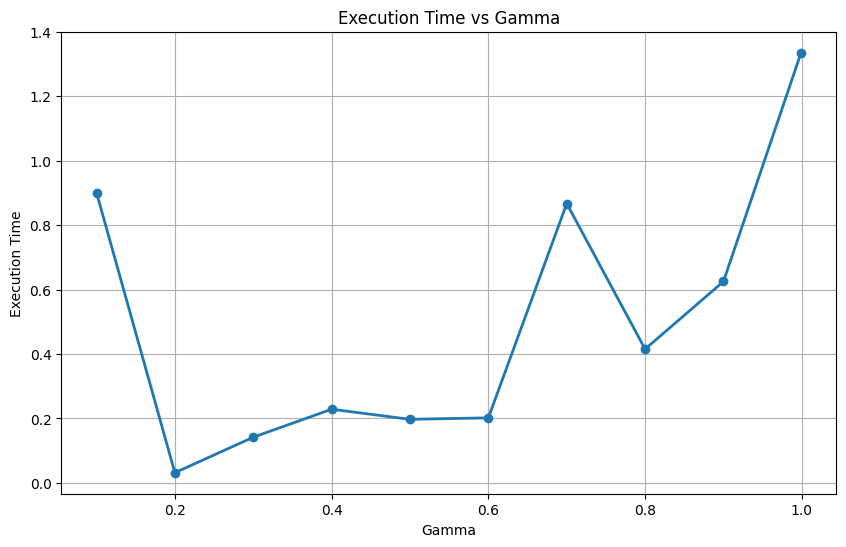

In [119]:
pi_data.plot(x='gamma', y='reward', title='Rewards vs. Gamma')
plt.grid()

pi_data.plot(x='iterations', y='reward', title='Rewards vs. Iterations')
plt.grid()
plot_results(pi_data)

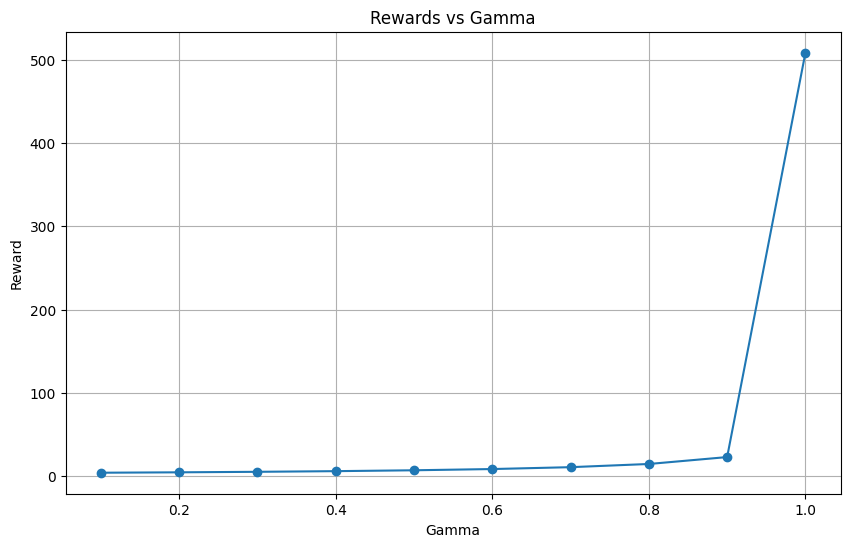

In [131]:
import pandas as pd
import matplotlib.pyplot as plt

# Given data
data = {
    'gamma': [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00],
    'time': [1.12, 0.04, 0.53, 0.19, 0.16, 0.43, 0.47, 0.63, 0.97, 1.98],
    'iter': [1, 1, 2, 2, 3, 3, 5, 6, 10, 20],
    'reward': [4.396613, 4.882699, 5.491933, 6.277574, 7.329154, 8.809994, 11.054551, 14.883721, 23.172434, 508.385877]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot rewards vs gamma
plt.figure(figsize=(10, 6))
plt.plot(df['gamma'], df['reward'], marker='o')
plt.xlabel('Gamma')
plt.ylabel('Reward')
plt.title('Rewards vs Gamma')
plt.grid(True)
plt.show()


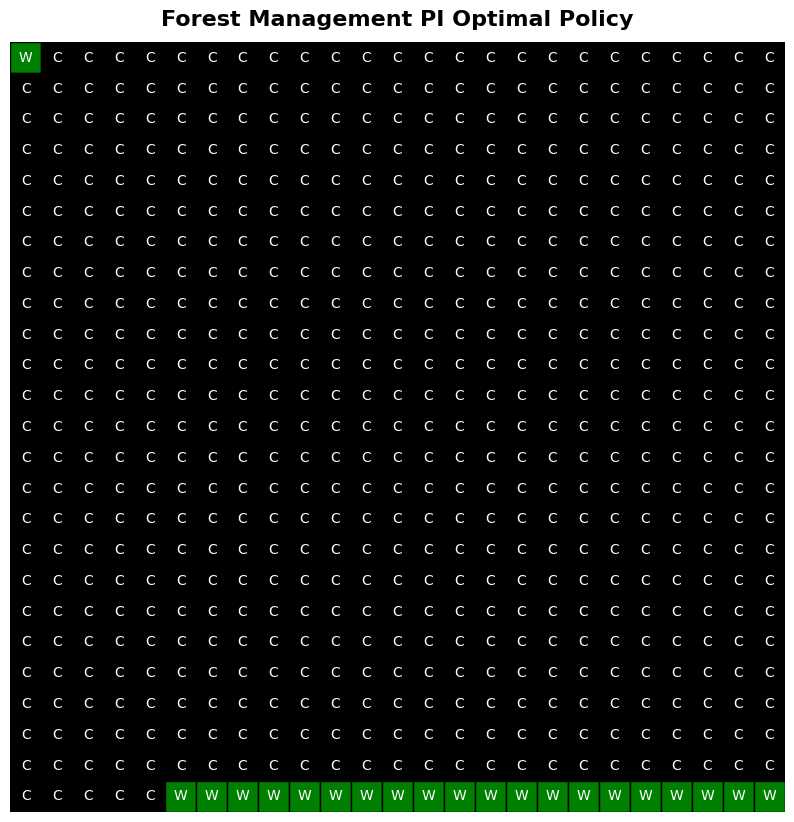

Best Result:
	Reward = 508.39
	Gamma = 0.999


In [110]:
bestRun = pi_data['reward'].argmax()
bestPolicy = pi_data['policy'][bestRun]

title='Forest Management PI Optimal Policy'
plot_forest(bestPolicy, title)

print('Best Result:\n\tReward = %.2f\n\tGamma = %.3f' % (pi_data['reward'].max(), pi_data['gamma'][bestRun]))

In [132]:
def qLearning(t, r, gammas, alphas, alpha_decays=[0.99], epsilon_decays=[0.99], n_iterations=[10000000], showResults=False):
    # create data structure to save off
    columns = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'time', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    numTests = len(gammas)*len(alphas)*len(alpha_decays)*len(epsilon_decays)*len(n_iterations)
    data = pd.DataFrame(0.0, index=np.arange(numTests), columns=columns)
    
    print('Gamma,\tAlpha,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for a in alphas:
            for a_decay in alpha_decays:
                for e_decay in epsilon_decays:
                    for n in n_iterations:
                        print('Test Num %d/%d' %(testNum+1, numTests))
                        print('Gamma: %.2f,\tAlpha: %.2f,\tAlpha Decay:%.3f,\tEpsilon Decay:%.3f,\tIterations:%d' 
                             %(g, a, a_decay, e_decay, n))
                        
                        test = QLearning(t, r, gamma=g, alpha=a, alpha_decay=a_decay, epsilon_decay=e_decay, n_iter=n)
                        
                        runs  = test.run()
                        time  = runs[-1]['Time']
                        iters = runs[-1]['Iteration']
                        maxR  = runs[-1]['Max V']
                        
                        max_rewards, mean_rewards, errors = [], [], []
                        for run in runs:
                            max_rewards.append(run['Max V'])
                            mean_rewards.append(run['Mean V'])
                            errors.append(run['Error'])
                        
                        #policy = np.array(test.policy)
                        #policy = policy.reshape(4,4)
                        
                        data['gamma'][testNum]         = g
                        data['alpha'][testNum]         = a
                        data['alpha_decay'][testNum]   = a_decay
                        data['epsilon_decay'][testNum] = e_decay
                        data['time'][testNum]          = time
                        data['iterations'][testNum]    = iters
                        data['reward'][testNum]        = maxR
                        data['mean_rewards'][testNum]  = {tuple(mean_rewards)}
                        data['max_rewards'][testNum]   = {tuple(max_rewards)}
                        data['error'][testNum]         = {tuple(errors)}
                        data['policy'][testNum]        = {test.policy}
                        
                        print('%.2f,\t%.2f,\t%.2f,\t%d,\t%f' % (g, a, time, iters, maxR))
                        
                        if showResults:
                            pass
                        
                        testNum = testNum + 1
            
    # See differences in policy
    policies = data['policy']

    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

In [153]:
# gammas         = [0.9, 0.99]
# alphas         = [0.01, 0.1]
# alpha_decays   = [0.9, 0.999]
# epsilon_decays = [0.9, 0.999]
# iterations     = [1e4, 1e5]

gammas   = [ 0.9, 0.9999999]
alphas         = [0.001, 0.01, 0.1]
alpha_decays   = [0.5, 0.9, 0.99, 0.999]
epsilon_decays = [0.99, 0.999]
iterations     = [1e4, 1e5, 1e6]


In [ ]:
ql_data  = qLearning(T, R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=False)

# write all results to csv file
csvFile = 'QL_results.csv'
ql_data.to_csv(csvFile)

ql_data.head()

In [155]:
interest = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'reward', 'time']

# pick out hyperparameters and how succesful they were
df = ql_data[interest]

# See what affected the success_pct the most
ql_corr = df.corr()

<Axes: title={'center': 'Correlation Matrix of Q-Learning Parameters'}>

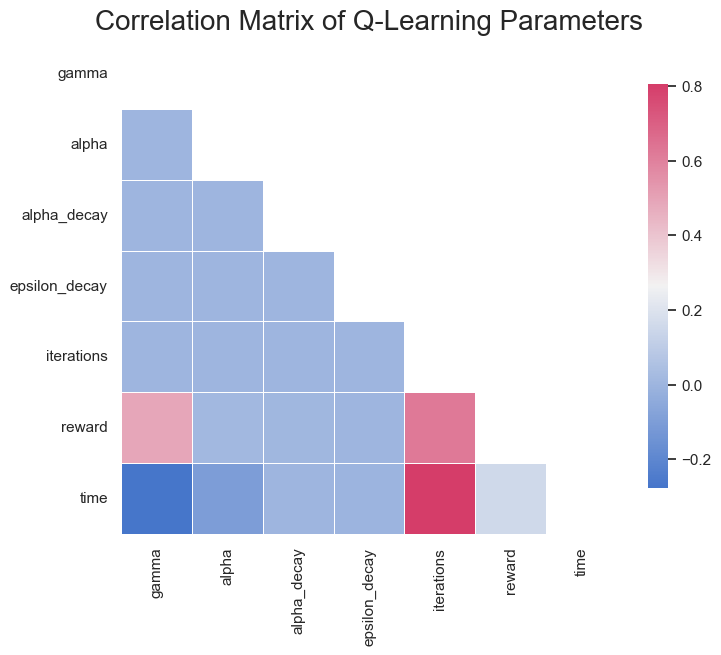

In [156]:
sns.set(style="white")
fig, ax = plt.subplots(figsize=(8,7))
ax.set_title('Correlation Matrix of Q-Learning Parameters', fontsize=20)
mask = np.triu(np.ones_like(ql_corr, dtype=bool))
cmap = sns.diverging_palette(255, 0, as_cmap=True)
sns.heatmap(ql_corr, mask=mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink":.75})

In [163]:
def plot_QL(dependent, independent, title=None, logscale=False):
    if dependent not in interest:
        print('Dependent variable not available')
        return
    if independent not in interest:
        print('Independent variable not available')
        return
    
    x = np.unique(df[dependent])
    y = []
    
    for i in x:
        y.append(df.loc[df[dependent] == i][independent].mean())
        
    fig = plt.figure(figsize=(10,6))
    plt.plot(x, y, 'o-')
    
    if title == None:
        title = independent + ' vs. ' + dependent
    # plt.figure(figsize=(10, 6))
    plt.title(title, fontsize=15)
    plt.xlabel(dependent)
    plt.ylabel(independent)
    plt.grid(True)
    if logscale:
        plt.xscale('log')
    
    title='QL_' + independent + '_vs_' + dependent
    plt.show()

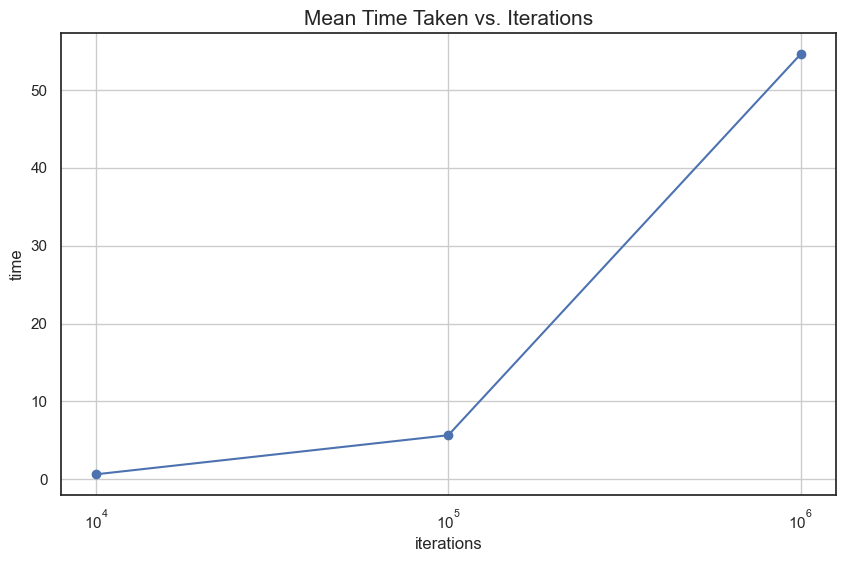

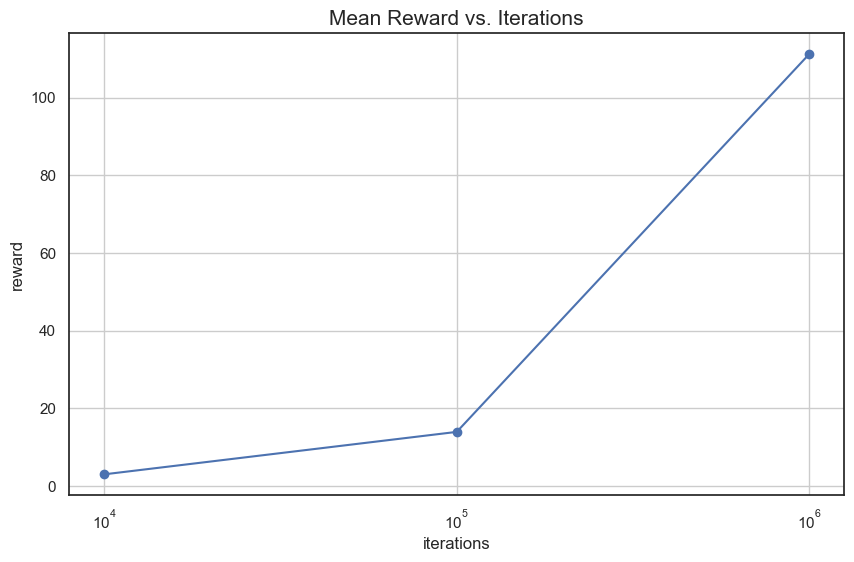

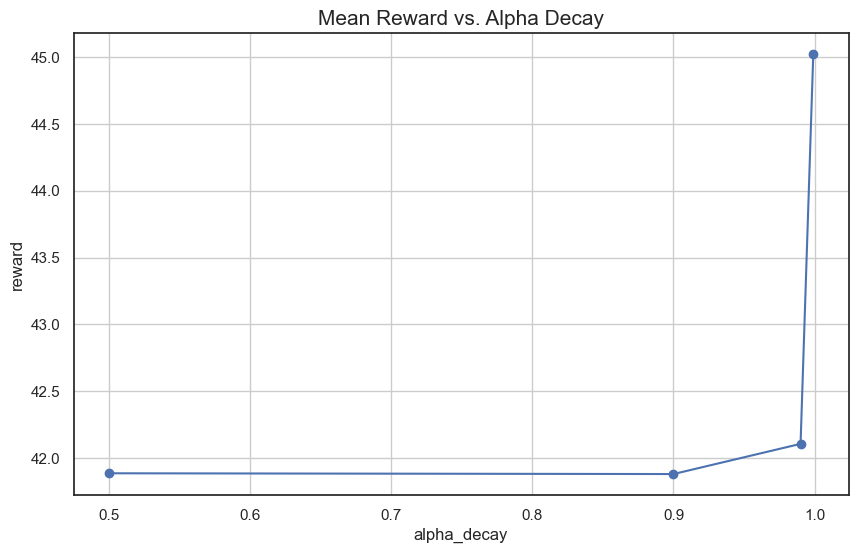

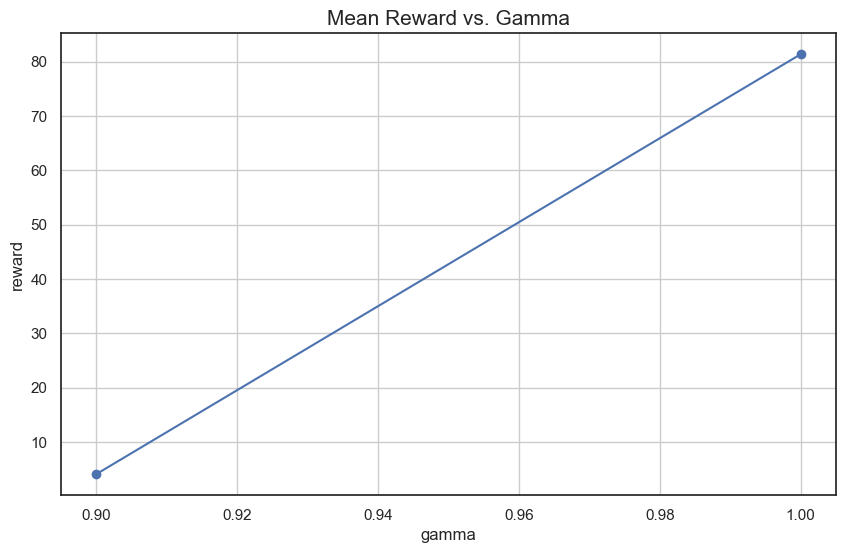

In [164]:
# Plot time vs. Iterations
plot_QL('iterations', 'time', title='Mean Time Taken vs. Iterations', logscale=True)

plot_QL('iterations', 'reward', title='Mean Reward vs. Iterations', logscale=True)

# Plot alpha decay vs success pct
plot_QL('alpha_decay', 'reward', title='Mean Reward vs. Alpha Decay')

# Plot results vs. gamma
plot_QL('gamma', 'reward', title='Mean Reward vs. Gamma')

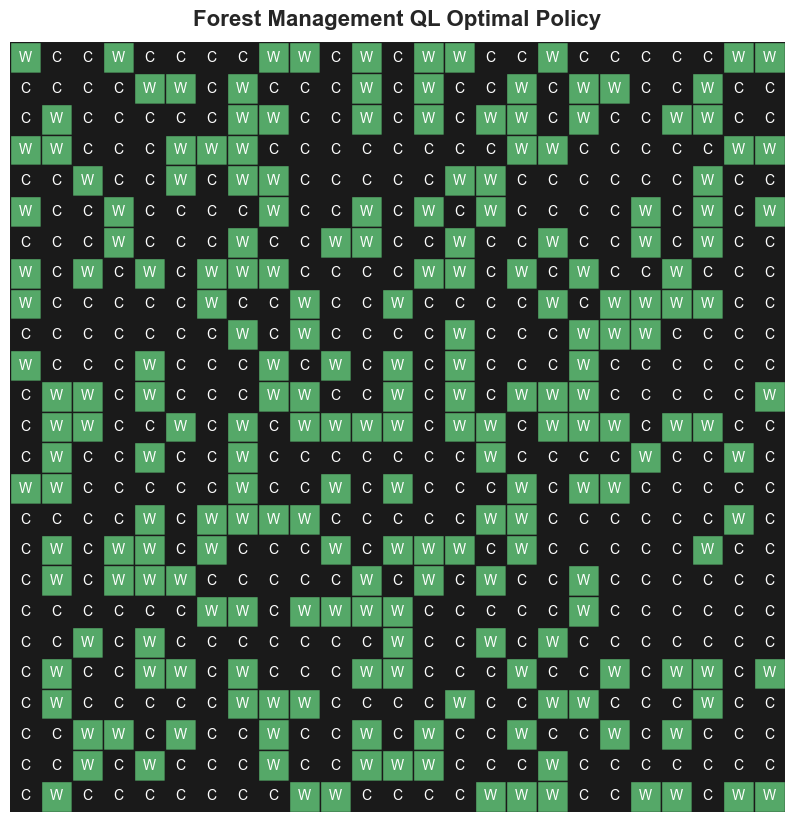

Best Result:
	Reward = 234.21
	Gamma = 1.00,
	Alpha = 0.10,
	Alpha Decay: 0.999,
	Epsilon Decay: 0.990,
	Iterations: 1.0E+06


In [159]:
bestRun = ql_data['reward'].argmax()

best_policy = str(ql_data['policy'][bestRun])

# reshape the policy since we pulled from a csv file
best_policy = best_policy[1:-1]
best_policy = eval(best_policy)
best_policy = np.array(best_policy)
best_policy = best_policy.reshape(25, 25)

# plot the policy
title='Forest Management QL Optimal Policy'
plot_forest(best_policy, title)

print('Best Result:\n\tReward = %.2f\n\tGamma = %.2f,\n\tAlpha = %.2f,\n\tAlpha Decay: %.3f,\n\tEpsilon Decay: %.3f,\n\tIterations: %.1E' 
      % (ql_data['reward'].max(), ql_data['gamma'][bestRun], ql_data['alpha'][bestRun], ql_data['alpha_decay'][bestRun], ql_data['epsilon_decay'][bestRun], ql_data['iterations'][bestRun]))

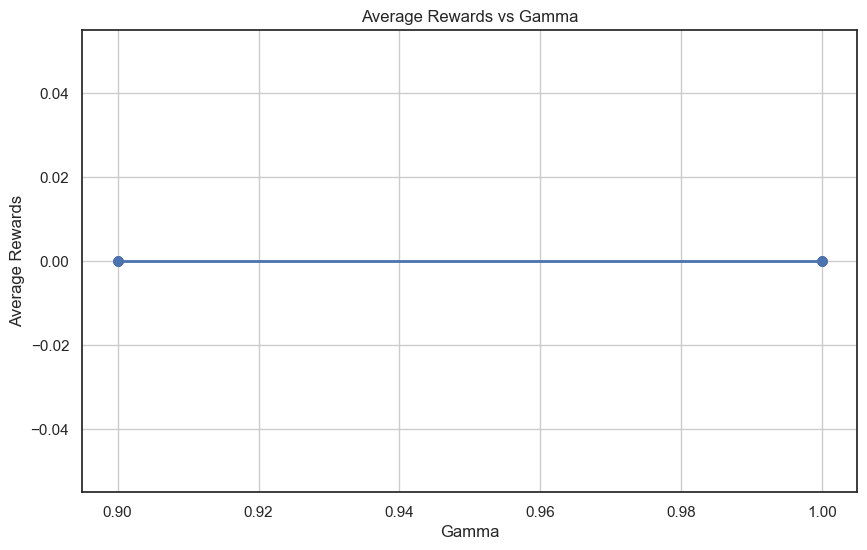

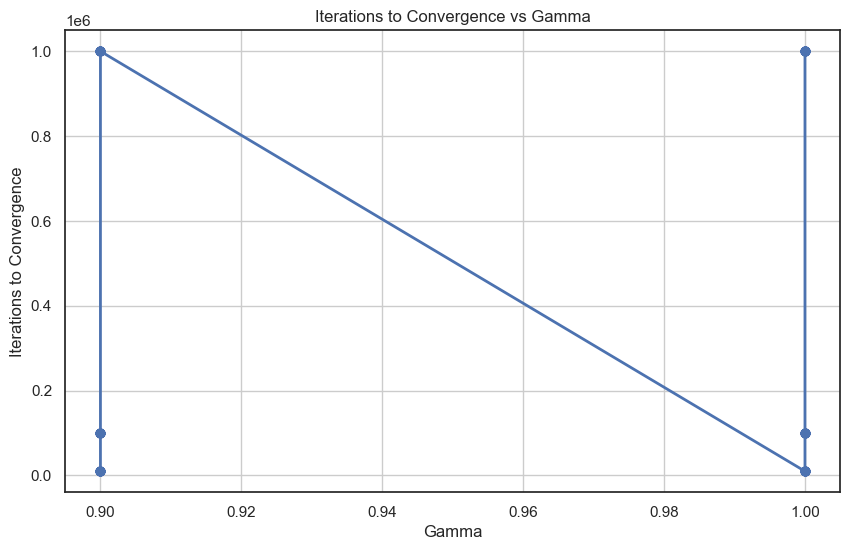

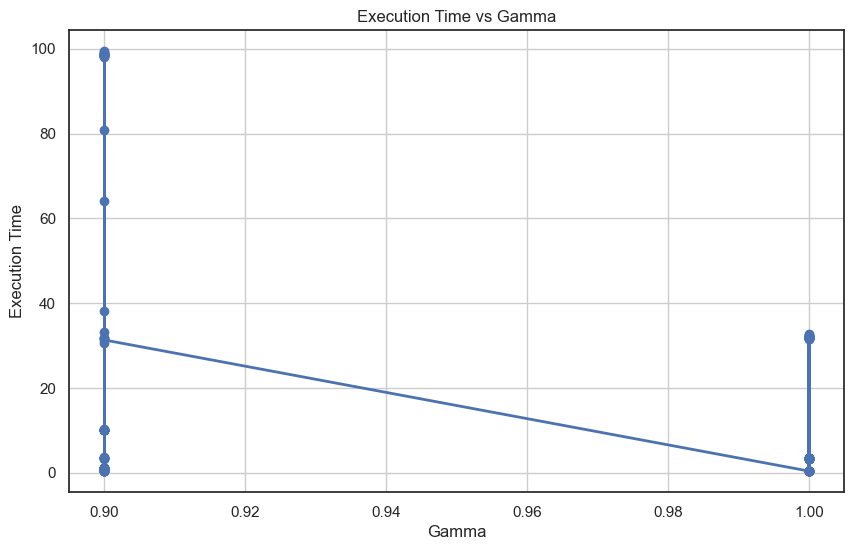

In [160]:
plot_results(ql_data)